In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Nevanlinna
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR

In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

In [3]:
beta = 100
wmax = 10
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 
;

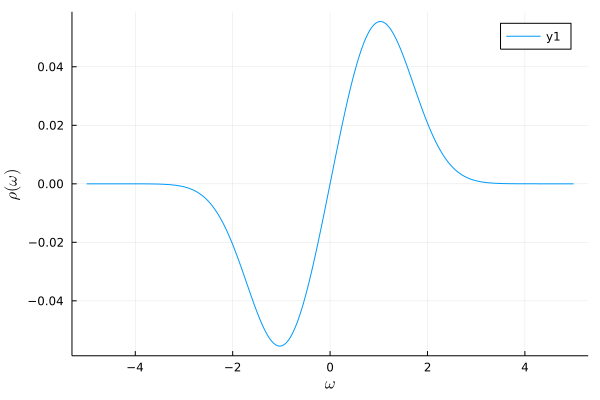

In [4]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#rho(omega) = gaussian(omega, 0.0, 0.15)  
rho(omega) = (0.1*gaussian(omega, 1, 1) - 0.1*gaussian(omega, -1, 1))/tanh(0.5*beta*omega)
#rho(omega) = (1*gaussian(omega, 1, 1) - 1*gaussian(omega, -1, 1))/tanh(0.5*beta*omega)
#rho(omega) = 0.1*gaussian(omega, 0, 1)


omegas = LinRange(-5, 5, 1000)
plot(omegas, rho.(omegas).*tanh.(0.5*beta*omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))
#plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [5]:
rhol_f = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
rhol_b = [overlap(IR_basis_set.basis_b.v[l], rho) for l in 1:length(IR_basis_set.basis_b)]
rhol_f == rhol_b

true

In [6]:
gl_f = - IR_basis_set.basis_f.s .* rhol_f
gl_b = - IR_basis_set.basis_b.s .* rhol_b
gl_f == gl_b

true

In [7]:
rhol = [overlap(IR_basis_set.basis_b.v[l], rho) for l in 1:length(IR_basis_set.basis_b)]
gl = - IR_basis_set.basis_b.s .* rhol
;

In [8]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

36

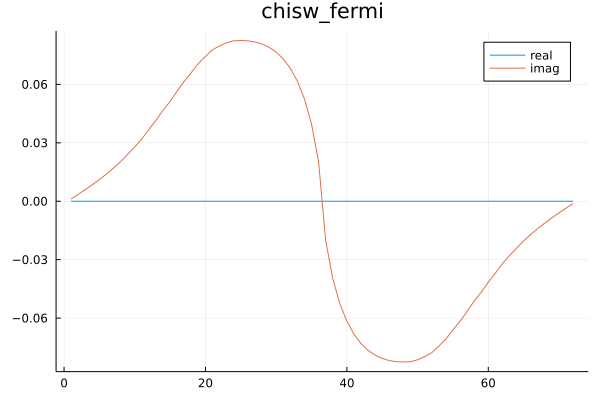

In [9]:
plot(title="chisw_fermi")
plot!(real.(gw[:]), label="real")
plot!(imag.(gw[:]), label="imag")

In [10]:
sum = -dot(IR_basis_set.basis_f.u(beta), gl) - dot(IR_basis_set.basis_f.u(0), gl)

0.16859477735722417

In [11]:
setprecision(512)

512

In [12]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [13]:
for i in 1:hnw
    test_smpl[i]= SparseIR.valueim(IR_basis_set.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(IR_basis_set))
    test_gw[i]  = gw[hnw+i]
end

In [14]:
N_real    =  6000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
println("N_imag $(N_imag)")

N_imag is setted as 29
N_imag 29


In [15]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     3.631342e-04     5.903603e-03
 * time: 0.020709991455078125
     1     1.552102e-04     2.452296e-03
 * time: 3.9851720333099365
     2     1.087986e-04     2.903822e-03
 * time: 6.898789882659912
     3     3.511180e-05     6.106668e-05
 * time: 9.86487603187561
     4     3.507113e-05     3.798532e-07
 * time: 12.007317066192627
     5     3.507113e-05     1.243027e-09
 * time: 14.149177074432373
max_theta=0.0602024252989396073452189852706519064291179153076817876324276451289216023877704331350135614412590076644642628248002253088727937649553673534205398604299588653
hardy optimization was success.
 54.253818 seconds (278.70 M allocations: 17.409 GiB, 14.05% gc time, 68.45% compilation time)


In [16]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     3.507113e-05     1.243027e-09
 * time: 0.00019311904907226562
max_theta=0.0602024252989396073452189852706519064291179153076817876324276451289216023877704331350135614412590076644642628248002253088727937649553673534205398604299588653
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     3.507113e-05     1.180566e-03
 * time: 0.00020003318786621094
     1     2.161866e-05     9.120068e-04
 * time: 3.3847100734710693
     2     1.052676e-05     2.760700e-04
 * time: 7.122648000717163
     3     9.930468e-06     1.242383e-04
 * time: 10.514254093170166
     4     9.744201e-06     9.519865e-05
 * time: 12.966008186340332
     5     6.784391e-06     5.699605e-05
 * time: 18.298999071121216
     6     6.624267e-06     2.593606e-07
 * time: 21.089241981506348
     7     6.624262e-06     2.641681e-09
 * time: 23.720134973526
max_theta=0.08220401607248050776679870287387823728011242194553860085266995295484284

     2     3.280732e-06     1.205765e-06
 * time: 10.824960947036743
     3     3.280704e-06     1.040964e-06
 * time: 16.58178687095642
     4     3.280684e-06     8.697342e-07
 * time: 22.34523296356201
     5     3.280666e-06     6.274084e-07
 * time: 27.424625873565674
     6     3.280661e-06     6.935955e-07
 * time: 31.31549096107483
     7     3.280640e-06     6.107850e-07
 * time: 37.00340700149536
     8     3.280614e-06     7.518875e-07
 * time: 44.02299499511719
     9     3.280586e-06     4.611742e-07
 * time: 49.87297987937927
    10     3.280584e-06     4.459219e-07
 * time: 53.73489785194397
    11     3.280570e-06     3.719989e-07
 * time: 59.660847902297974
    12     3.280556e-06     3.933801e-07
 * time: 66.16703391075134
    13     3.280555e-06     3.349012e-07
 * time: 70.6166660785675
    14     3.280541e-06     3.257254e-07
 * time: 76.42011404037476
    15     3.280519e-06     2.112630e-07
 * time: 82.96429705619812
    16     3.280518e-06     2.254099e-07
 * ti

max_theta=0.237478855214037107226841986398041031754821160422367176212605284047789022052675567555132857924570023987645790270702894689108193920383539941530902082065345805
hardy optimization was success.
H=12
Iter     Function value   Gradient norm 
     0     3.275590e-06     8.900263e-07
 * time: 0.00019288063049316406
     1     3.275575e-06     1.982120e-06
 * time: 9.002947807312012
     2     3.275551e-06     9.705025e-07
 * time: 16.279944896697998
     3     3.275539e-06     7.076828e-07
 * time: 22.714168787002563
     4     3.275530e-06     6.728645e-07
 * time: 29.164031982421875
     5     3.275521e-06     6.905178e-07
 * time: 36.05555701255798
     6     3.275512e-06     5.154751e-07
 * time: 42.96952795982361
     7     3.275508e-06     5.406175e-07
 * time: 48.71799278259277
     8     3.275495e-06     5.386579e-07
 * time: 56.002967834472656
     9     3.275486e-06     4.746052e-07
 * time: 62.53305101394653
    10     3.275477e-06     4.200663e-07
 * time: 69.77296185493

    37     3.272195e-06     1.740757e-08
 * time: 303.03704810142517
    38     3.271712e-06     1.020352e-06
 * time: 320.8832561969757
    39     3.271621e-06     6.430756e-09
 * time: 326.3791000843048
max_theta=0.261901954232227916135723761232600225767612025490316957898074825711697489203446732722942367960531032400277591673639777006179104208020178851614788699614838829
hardy optimization was success.
H=15
Iter     Function value   Gradient norm 
     0     3.271621e-06     8.234543e-07
 * time: 0.0002589225769042969
     1     3.271616e-06     1.057204e-06
 * time: 8.275337934494019
     2     3.271601e-06     1.414356e-06
 * time: 16.737653017044067
     3     3.271576e-06     1.409990e-06
 * time: 25.367671966552734
     4     3.271555e-06     1.182914e-06
 * time: 33.88414812088013
     5     3.271541e-06     1.096512e-06
 * time: 41.44278907775879
     6     3.271525e-06     8.949733e-07
 * time: 49.436280965805054
     7     3.271509e-06     8.958515e-07
 * time: 57.226969003677

    17     3.266125e-06     7.875418e-07
 * time: 144.1507921218872
    18     3.266090e-06     6.124191e-07
 * time: 153.545175075531
    19     3.266054e-06     5.873939e-07
 * time: 164.16951608657837
    20     3.266049e-06     5.642163e-07
 * time: 171.54619812965393
    21     3.265999e-06     5.623825e-07
 * time: 180.22881317138672
    22     3.265964e-06     5.363015e-07
 * time: 191.97601795196533
    23     3.265962e-06     5.445314e-07
 * time: 199.1900360584259
    24     3.265916e-06     6.050927e-07
 * time: 209.52682614326477
    25     3.265896e-06     1.098083e-06
 * time: 220.95961093902588
    26     3.265835e-06     5.737631e-07
 * time: 228.47736597061157
    27     3.265800e-06     3.563492e-07
 * time: 239.16760206222534
    28     3.265796e-06     4.043101e-07
 * time: 245.53030610084534
    29     3.265737e-06     3.251816e-07
 * time: 260.1513171195984
    30     3.265735e-06     3.201391e-07
 * time: 266.8394000530243
    31     3.265665e-06     2.958105e-07

    15     3.257321e-06     1.471163e-06
 * time: 135.93349289894104
    16     3.257258e-06     1.270839e-06
 * time: 146.19446206092834
    17     3.257244e-06     1.185768e-06
 * time: 153.19398093223572
    18     3.257195e-06     1.112025e-06
 * time: 162.6124348640442
    19     3.257177e-06     9.312275e-07
 * time: 172.71754908561707
    20     3.257126e-06     8.795306e-07
 * time: 179.7742998600006
    21     3.257097e-06     5.878151e-07
 * time: 188.69360303878784
    22     3.257066e-06     8.460477e-07
 * time: 196.84070086479187
    23     3.257050e-06     6.901871e-07
 * time: 207.11953592300415
    24     3.256987e-06     6.943434e-07
 * time: 216.32994103431702
    25     3.256982e-06     7.064849e-07
 * time: 223.82501888275146
    26     3.256947e-06     5.568597e-07
 * time: 234.30964708328247
    27     3.256929e-06     7.827685e-07
 * time: 242.56882095336914
    28     3.256917e-06     6.773586e-07
 * time: 252.0210030078888
    29     3.256837e-06     6.909358e

    49     3.246459e-06     3.900432e-07
 * time: 418.8067078590393
    50     3.246442e-06     2.978609e-07
 * time: 429.15915393829346
    51     3.246400e-06     2.864965e-07
 * time: 437.0122480392456
    52     3.246374e-06     3.932524e-07
 * time: 444.0908570289612
    53     3.246370e-06     3.868613e-07
 * time: 450.87909293174744
    54     3.246369e-06     3.683167e-07
 * time: 457.6501359939575
    55     3.246363e-06     3.844525e-07
 * time: 464.4449348449707
    56     3.246336e-06     2.313896e-07
 * time: 472.52418303489685
    57     3.246305e-06     2.635613e-07
 * time: 480.8292980194092
    58     3.246289e-06     2.455298e-07
 * time: 488.20772886276245
    59     3.246288e-06     2.379171e-07
 * time: 495.3717129230499
    60     3.246286e-06     2.191555e-07
 * time: 503.1684989929199
    61     3.246274e-06     2.567254e-07
 * time: 513.8956129550934
    62     3.246242e-06     1.751131e-07
 * time: 521.022843837738
    63     3.246207e-06     1.919805e-07
 * t

   170     3.245079e-06     1.246237e-08
 * time: 1251.106539964676
   171     3.245079e-06     1.244387e-08
 * time: 1255.7673568725586
   172     3.245079e-06     1.242706e-08
 * time: 1261.4955508708954
   173     3.245079e-06     1.244505e-08
 * time: 1266.1201968193054
   174     3.245079e-06     1.243589e-08
 * time: 1270.676076889038
   175     3.245079e-06     1.246603e-08
 * time: 1276.3750779628754
   176     3.245079e-06     1.244799e-08
 * time: 1281.4959628582
   177     3.245079e-06     1.246026e-08
 * time: 1287.4311158657074
   178     3.245078e-06     1.243651e-08
 * time: 1292.1776509284973
   179     3.245078e-06     1.244692e-08
 * time: 1296.7813189029694
   180     3.245078e-06     1.241807e-08
 * time: 1302.5810239315033
   181     3.245078e-06     1.244318e-08
 * time: 1307.4626848697662
   182     3.245078e-06     1.240830e-08
 * time: 1312.2884459495544
   183     3.245078e-06     1.243993e-08
 * time: 1316.833093881607
   184     3.245078e-06     1.239882e-08

    65     3.244078e-06     1.947143e-07
 * time: 544.5339748859406
    66     3.244066e-06     1.774559e-07
 * time: 552.1698789596558
    67     3.244057e-06     2.173456e-07
 * time: 560.6757609844208
    68     3.244055e-06     2.072664e-07
 * time: 569.0840129852295
    69     3.244054e-06     1.963500e-07
 * time: 573.9174909591675
    70     3.244053e-06     1.789462e-07
 * time: 581.1059000492096
    71     3.244049e-06     2.176122e-07
 * time: 590.8129410743713
    72     3.244041e-06     2.064027e-07
 * time: 599.4589169025421
    73     3.244029e-06     2.251838e-07
 * time: 607.8102369308472
    74     3.244016e-06     3.473050e-07
 * time: 615.0061299800873
    75     3.244012e-06     3.171734e-07
 * time: 622.1240949630737
    76     3.244011e-06     3.096270e-07
 * time: 627.91211104393
    77     3.244009e-06     3.070603e-07
 * time: 637.3740499019623
    78     3.244003e-06     3.143483e-07
 * time: 644.5676860809326
    79     3.243987e-06     2.493888e-07
 * time: 

   185     3.243358e-06     2.998801e-07
 * time: 1365.4689869880676
   186     3.243346e-06     2.572938e-07
 * time: 1370.3225450515747
   187     3.243318e-06     3.766126e-07
 * time: 1377.6753420829773
   188     3.243300e-06     3.275549e-07
 * time: 1383.6263530254364
   189     3.243252e-06     4.697698e-07
 * time: 1392.2954149246216
   190     3.243224e-06     4.149982e-07
 * time: 1397.3029820919037
   191     3.243133e-06     5.591627e-07
 * time: 1405.6247200965881
   192     3.243081e-06     4.984586e-07
 * time: 1410.3296949863434
   193     3.242843e-06     4.750461e-07
 * time: 1419.8467199802399
   194     3.242418e-06     1.076664e-06
 * time: 1429.3030700683594
   195     3.242261e-06     9.549596e-07
 * time: 1435.1342029571533
   196     3.242169e-06     3.875724e-07
 * time: 1443.5178830623627
   197     3.242145e-06     4.585492e-07
 * time: 1449.1891260147095
   198     3.242120e-06     1.404503e-07
 * time: 1457.8793148994446
   199     3.242110e-06     1.6458

   305     3.241552e-06     3.185247e-08
 * time: 2161.5311000347137
   306     3.241552e-06     2.012694e-08
 * time: 2169.8182299137115
   307     3.241552e-06     2.234335e-08
 * time: 2174.813185930252
   308     3.241552e-06     2.057424e-08
 * time: 2183.272875070572
   309     3.241552e-06     2.419873e-08
 * time: 2188.2733659744263
   310     3.241552e-06     2.037342e-08
 * time: 2195.6857669353485
   311     3.241552e-06     2.102055e-08
 * time: 2200.585872888565
   312     3.241552e-06     2.085067e-08
 * time: 2209.0361070632935
   313     3.241552e-06     2.259552e-08
 * time: 2214.119590997696
   314     3.241552e-06     1.754646e-08
 * time: 2222.2730350494385
   315     3.241552e-06     1.953002e-08
 * time: 2226.978302001953
   316     3.241552e-06     1.976377e-08
 * time: 2235.123149871826
   317     3.241552e-06     2.146258e-08
 * time: 2240.247132062912
   318     3.241552e-06     2.126814e-08
 * time: 2248.797884941101
   319     3.241552e-06     2.286796e-08
 

    28     3.210616e-06     2.367515e-06
 * time: 274.094624042511
    29     3.210171e-06     3.228178e-06
 * time: 283.0974099636078
    30     3.210036e-06     3.680015e-06
 * time: 291.00996494293213
    31     3.209692e-06     1.574585e-06
 * time: 302.4931318759918
    32     3.209212e-06     2.388717e-06
 * time: 310.85692381858826
    33     3.209093e-06     2.241231e-06
 * time: 320.1433069705963
    34     3.209004e-06     1.941881e-06
 * time: 331.5808389186859
    35     3.208684e-06     1.363835e-06
 * time: 343.361202955246
    36     3.208249e-06     2.682864e-06
 * time: 351.0995578765869
    37     3.208177e-06     2.829061e-06
 * time: 359.50479197502136
    38     3.207966e-06     1.577570e-06
 * time: 371.18318796157837
    39     3.207488e-06     8.942974e-07
 * time: 379.1871178150177
    40     3.207317e-06     1.201321e-06
 * time: 384.5272250175476
    41     3.207297e-06     1.176153e-06
 * time: 392.38397884368896
    42     3.207216e-06     1.211506e-06
 * t

   149     3.204185e-06     3.391375e-08
 * time: 1194.8983719348907
   150     3.204185e-06     3.257673e-08
 * time: 1201.0938928127289
   151     3.204185e-06     3.112903e-08
 * time: 1206.2020180225372
   152     3.204185e-06     3.036017e-08
 * time: 1211.2748448848724
   153     3.204185e-06     2.945937e-08
 * time: 1216.330363035202
   154     3.204185e-06     2.928400e-08
 * time: 1221.277456998825
   155     3.204185e-06     2.894146e-08
 * time: 1226.2770149707794
   156     3.204185e-06     2.958272e-08
 * time: 1232.3129589557648
   157     3.204185e-06     2.994635e-08
 * time: 1237.95206284523
   158     3.204185e-06     3.056031e-08
 * time: 1244.4484758377075
   159     3.204185e-06     3.110462e-08
 * time: 1249.9231250286102
   160     3.204184e-06     3.134809e-08
 * time: 1255.2236440181732
   161     3.204184e-06     3.165995e-08
 * time: 1261.6294429302216
   162     3.204184e-06     3.148831e-08
 * time: 1267.2074818611145
   163     3.204184e-06     3.144313e-

   269     3.204154e-06     1.879309e-08
 * time: 1916.5378420352936
   270     3.204154e-06     2.082012e-08
 * time: 1925.3966488838196
   271     3.204154e-06     1.881686e-08
 * time: 1930.4462759494781
   272     3.204154e-06     2.109807e-08
 * time: 1939.4937489032745
   273     3.204154e-06     1.912933e-08
 * time: 1945.0259590148926
   274     3.204154e-06     2.119328e-08
 * time: 1953.1032338142395
   275     3.204154e-06     1.909510e-08
 * time: 1959.3822948932648
   276     3.204154e-06     2.126629e-08
 * time: 1967.2203278541565
   277     3.204154e-06     1.897173e-08
 * time: 1972.2484698295593
   278     3.204154e-06     2.163259e-08
 * time: 1981.3097360134125
   279     3.204154e-06     1.931170e-08
 * time: 1986.566339969635
   280     3.204154e-06     2.188845e-08
 * time: 1994.342113018036
   281     3.204154e-06     1.951233e-08
 * time: 1999.4895629882812
   282     3.204154e-06     2.204285e-08
 * time: 2008.6209230422974
   283     3.204154e-06     1.947589

   389     3.203845e-06     2.783023e-08
 * time: 2720.7090768814087
   390     3.203845e-06     2.363323e-08
 * time: 2727.01283288002
   391     3.203845e-06     2.463101e-08
 * time: 2732.147280931473
   392     3.203845e-06     2.402101e-08
 * time: 2737.138417005539
   393     3.203845e-06     2.482407e-08
 * time: 2743.4528439044952
   394     3.203845e-06     2.291477e-08
 * time: 2748.8118948936462
   395     3.203845e-06     2.337309e-08
 * time: 2754.1532249450684
   396     3.203844e-06     2.280744e-08
 * time: 2759.2763888835907
   397     3.203844e-06     2.326453e-08
 * time: 2764.4848449230194
   398     3.203844e-06     2.354137e-08
 * time: 2770.6935238838196
   399     3.203844e-06     2.495517e-08
 * time: 2775.8830909729004
   400     3.203844e-06     2.490706e-08
 * time: 2780.9180870056152
   401     3.203844e-06     2.633791e-08
 * time: 2787.289613008499
   402     3.203844e-06     2.382740e-08
 * time: 2792.49800491333
   403     3.203844e-06     2.450147e-08


   509     3.203826e-06     9.568311e-08
 * time: 3441.7038469314575
   510     3.203824e-06     1.087372e-07
 * time: 3450.246414899826
   511     3.203824e-06     9.733075e-08
 * time: 3455.813817024231
   512     3.203821e-06     1.091978e-07
 * time: 3465.2203209400177
   513     3.203820e-06     9.665668e-08
 * time: 3470.8287060260773
   514     3.203812e-06     9.206906e-08
 * time: 3482.4732048511505
   515     3.203783e-06     2.118716e-07
 * time: 3494.222324848175
   516     3.203764e-06     6.177225e-08
 * time: 3499.504245042801
   517     3.203752e-06     1.299393e-07
 * time: 3507.8712759017944
   518     3.203745e-06     4.457591e-08
 * time: 3513.2598419189453
   519     3.203737e-06     9.731229e-08
 * time: 3522.199280023575
   520     3.203734e-06     3.401150e-08
 * time: 3527.6593940258026
   521     3.203730e-06     7.922595e-08
 * time: 3535.424670934677
   522     3.203728e-06     2.407188e-08
 * time: 3540.4510419368744
   523     3.203726e-06     6.291372e-08

   629     3.203690e-06     1.404759e-07
 * time: 4245.927181005478
   630     3.203689e-06     1.684750e-07
 * time: 4250.979864835739
   631     3.203686e-06     2.164840e-07
 * time: 4259.2294998168945
   632     3.203685e-06     2.714432e-07
 * time: 4265.303833961487
   633     3.203681e-06     2.406631e-07
 * time: 4272.752200841904
   634     3.203679e-06     3.213144e-07
 * time: 4277.842403888702
   635     3.203675e-06     2.170118e-07
 * time: 4286.170068979263
   636     3.203674e-06     3.003965e-07
 * time: 4291.0792009830475
   637     3.203669e-06     1.717984e-07
 * time: 4298.1055998802185
   638     3.203667e-06     2.234289e-07
 * time: 4302.769152879715
   639     3.203663e-06     1.654805e-07
 * time: 4310.767524957657
   640     3.203661e-06     1.502604e-07
 * time: 4316.054268836975
   641     3.203656e-06     1.767215e-07
 * time: 4324.854562044144
   642     3.203654e-06     1.271734e-07
 * time: 4329.8112189769745
   643     3.203648e-06     1.483741e-07
 * 

   750     3.203592e-06     1.107825e-08
 * time: 4939.087568998337
   751     3.203592e-06     1.238732e-08
 * time: 4944.074398994446
   752     3.203592e-06     1.027072e-08
 * time: 4948.929651021957
   753     3.203592e-06     1.152445e-08
 * time: 4953.780025959015
   754     3.203592e-06     9.431837e-09
 * time: 4958.931895971298
max_theta=0.311905483350206496966217931839133877145397151385504499175494141867102511064198037476275869782621295185193157118785474557617342282343520070415275247570710197
hardy optimization was success.
H=23
Iter     Function value   Gradient norm 
     0     3.203592e-06     7.120564e-07
 * time: 0.00019788742065429688
     1     3.203585e-06     2.461732e-06
 * time: 14.310054063796997
     2     3.203570e-06     1.776378e-06
 * time: 22.959968090057373
     3     3.203560e-06     7.667943e-07
 * time: 30.69144105911255
     4     3.203558e-06     5.199116e-07
 * time: 38.35809302330017
     5     3.203556e-06     3.636616e-07
 * time: 45.7624480724334

   112     3.203011e-06     3.204678e-07
 * time: 886.0720889568329
   113     3.203004e-06     3.127405e-07
 * time: 893.6127328872681
   114     3.203000e-06     2.988643e-07
 * time: 899.8412089347839
   115     3.202996e-06     2.842668e-07
 * time: 907.7153499126434
   116     3.202993e-06     2.801710e-07
 * time: 916.5659689903259
   117     3.202990e-06     2.692130e-07
 * time: 924.5106029510498
   118     3.202985e-06     2.974425e-07
 * time: 931.9884469509125
   119     3.202980e-06     3.985007e-07
 * time: 940.5415320396423
   120     3.202970e-06     2.990381e-07
 * time: 945.8539390563965
   121     3.202962e-06     3.920963e-07
 * time: 951.291403055191
   122     3.202954e-06     2.803276e-07
 * time: 957.754047870636
   123     3.202948e-06     3.724681e-07
 * time: 963.2713840007782
   124     3.202942e-06     2.585138e-07
 * time: 969.6464951038361
   125     3.202936e-06     3.520103e-07
 * time: 974.9657289981842
   126     3.202931e-06     2.389967e-07
 * time: 

   232     3.202368e-06     2.134698e-07
 * time: 1610.1750230789185
   233     3.202367e-06     2.140528e-07
 * time: 1615.0408840179443
   234     3.202366e-06     2.168926e-07
 * time: 1619.9162058830261
   235     3.202365e-06     2.169168e-07
 * time: 1624.8283989429474
   236     3.202365e-06     2.197170e-07
 * time: 1631.1264929771423
   237     3.202364e-06     2.192252e-07
 * time: 1636.6823558807373
   238     3.202363e-06     2.219230e-07
 * time: 1643.184877872467
   239     3.202362e-06     2.209871e-07
 * time: 1649.1754140853882
   240     3.202361e-06     2.235223e-07
 * time: 1654.5117590427399
   241     3.202360e-06     2.222017e-07
 * time: 1659.690614938736
   242     3.202359e-06     2.245357e-07
 * time: 1665.9414739608765
   243     3.202358e-06     2.228591e-07
 * time: 1671.0438630580902
   244     3.202357e-06     2.249763e-07
 * time: 1675.980465888977
   245     3.202356e-06     2.229469e-07
 * time: 1680.8952279090881
   246     3.202355e-06     2.248475e

   352     3.202270e-06     1.560711e-07
 * time: 2275.746183872223
   353     3.202269e-06     1.488780e-07
 * time: 2281.1193928718567
   354     3.202268e-06     1.486843e-07
 * time: 2286.2121369838715
   355     3.202267e-06     1.420430e-07
 * time: 2291.4655299186707
   356     3.202266e-06     1.478816e-07
 * time: 2296.5746998786926
   357     3.202265e-06     1.431233e-07
 * time: 2301.661153078079
   358     3.202264e-06     1.488928e-07
 * time: 2307.9872829914093
   359     3.202263e-06     1.442369e-07
 * time: 2313.2475230693817
   360     3.202262e-06     1.499208e-07
 * time: 2319.5415830612183
   361     3.202261e-06     1.453748e-07
 * time: 2325.095472097397
   362     3.202260e-06     1.509581e-07
 * time: 2331.0374069213867
   363     3.202259e-06     1.465272e-07
 * time: 2336.336534023285
   364     3.202258e-06     1.519969e-07
 * time: 2342.7174899578094
   365     3.202257e-06     1.476842e-07
 * time: 2348.3159699440002
   366     3.202256e-06     1.530294e-

   472     3.202053e-06     2.148741e-07
 * time: 3015.220846891403
   473     3.202049e-06     1.242890e-07
 * time: 3024.0701270103455
   474     3.202046e-06     2.131501e-07
 * time: 3029.283513069153
   475     3.202042e-06     1.268245e-07
 * time: 3037.0763969421387
   476     3.202040e-06     2.134670e-07
 * time: 3042.137074947357
   477     3.202035e-06     1.322019e-07
 * time: 3049.6767098903656
   478     3.202033e-06     2.146940e-07
 * time: 3055.998116016388
   479     3.202028e-06     1.398079e-07
 * time: 3063.91987490654
   480     3.202026e-06     2.144913e-07
 * time: 3070.406688928604
   481     3.202021e-06     1.475916e-07
 * time: 3079.10773396492
   482     3.202018e-06     2.062451e-07
 * time: 3084.421511888504
   483     3.202012e-06     1.500127e-07
 * time: 3093.26296210289
   484     3.202008e-06     1.473534e-07
 * time: 3101.0750958919525
   485     3.202005e-06     1.570692e-07
 * time: 3108.899349927902
   486     3.202004e-06     1.426589e-07
 * tim

   592     3.201875e-06     9.501518e-08
 * time: 3788.905580997467
   593     3.201873e-06     2.146696e-07
 * time: 3795.1090080738068
   594     3.201872e-06     9.412727e-08
 * time: 3800.5701348781586
   595     3.201870e-06     2.137876e-07
 * time: 3805.9241960048676
   596     3.201868e-06     9.322820e-08
 * time: 3810.9992110729218
   597     3.201866e-06     2.127673e-07
 * time: 3816.11435008049
   598     3.201864e-06     9.212343e-08
 * time: 3822.439817905426
   599     3.201862e-06     2.116605e-07
 * time: 3827.996948003769
   600     3.201860e-06     9.066825e-08
 * time: 3834.5094900131226
   601     3.201859e-06     2.104932e-07
 * time: 3840.057632923126
   602     3.201857e-06     8.894165e-08
 * time: 3846.462744951248
   603     3.201855e-06     2.092481e-07
 * time: 3852.0179839134216
   604     3.201853e-06     8.800857e-08
 * time: 3858.5155379772186
   605     3.201851e-06     2.079038e-07
 * time: 3864.5005180835724
   606     3.201850e-06     9.036907e-08


   713     3.200936e-06     3.065594e-07
 * time: 4582.432979106903
   714     3.200935e-06     2.018607e-07
 * time: 4587.658691883087
   715     3.200935e-06     3.029258e-07
 * time: 4593.991503953934
   716     3.200934e-06     2.046920e-07
 * time: 4599.4321229457855
   717     3.200933e-06     3.007420e-07
 * time: 4605.730180025101
   718     3.200932e-06     2.063204e-07
 * time: 4611.042507886887
   719     3.200931e-06     3.000015e-07
 * time: 4616.267613887787
   720     3.200931e-06     2.069345e-07
 * time: 4622.586858034134
   721     3.200930e-06     2.992775e-07
 * time: 4627.872526884079
   722     3.200929e-06     2.072422e-07
 * time: 4632.88564491272
   723     3.200929e-06     2.977162e-07
 * time: 4637.900724887848
   724     3.200928e-06     2.076291e-07
 * time: 4644.045001983643
   725     3.200927e-06     2.958151e-07
 * time: 4649.077975988388
   726     3.200927e-06     2.080310e-07
 * time: 4654.091015100479
   727     3.200926e-06     2.945708e-07
 * time

   834     3.200849e-06     2.323676e-07
 * time: 5239.057879924774
   835     3.200849e-06     3.278275e-07
 * time: 5245.06342792511
   836     3.200848e-06     2.329509e-07
 * time: 5250.25559592247
   837     3.200847e-06     3.286318e-07
 * time: 5255.387645959854
   838     3.200846e-06     2.335432e-07
 * time: 5260.618558883667
   839     3.200845e-06     3.294389e-07
 * time: 5266.188735961914
   840     3.200844e-06     2.341403e-07
 * time: 5271.75714802742
   841     3.200843e-06     3.302452e-07
 * time: 5276.741875886917
   842     3.200842e-06     2.347375e-07
 * time: 5282.89528799057
   843     3.200841e-06     3.310468e-07
 * time: 5288.477891921997
   844     3.200841e-06     2.353314e-07
 * time: 5293.9442529678345
   845     3.200840e-06     3.318410e-07
 * time: 5299.312365055084
   846     3.200839e-06     2.359201e-07
 * time: 5305.495791912079
   847     3.200838e-06     3.326271e-07
 * time: 5310.8515338897705
   848     3.200837e-06     2.365040e-07
 * time: 

   955     3.200725e-06     3.630459e-07
 * time: 5901.966125011444
   956     3.200724e-06     2.615892e-07
 * time: 5908.342097997665
   957     3.200723e-06     3.632099e-07
 * time: 5913.524131059647
   958     3.200721e-06     2.617670e-07
 * time: 5918.774440050125
   959     3.200720e-06     3.633519e-07
 * time: 5924.815675020218
   960     3.200719e-06     2.619277e-07
 * time: 5929.886575937271
   961     3.200718e-06     3.634717e-07
 * time: 5934.877464056015
   962     3.200717e-06     2.620710e-07
 * time: 5939.875497102737
   963     3.200716e-06     3.635687e-07
 * time: 5944.73516201973
   964     3.200715e-06     2.621966e-07
 * time: 5949.617110967636
   965     3.200713e-06     3.636427e-07
 * time: 5955.929913043976
   966     3.200712e-06     2.623040e-07
 * time: 5961.250295877457
   967     3.200711e-06     3.636932e-07
 * time: 5967.435184955597
   968     3.200710e-06     2.623929e-07
 * time: 5972.85884809494
   969     3.200709e-06     3.637196e-07
 * time: 

In [17]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


In [18]:
#plot(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*beta*real.(raw_reals.freq)),marker=:+)
plot(real.(raw_reals.freq), imag.(raw_reals.val/pi),marker=:+)

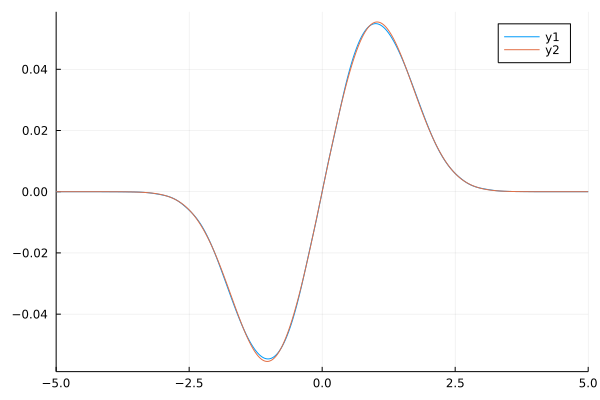

In [19]:
plot(xlim = [-5,5])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*beta*real.(raw_reals.freq)))
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val)).*tanh.(0.5*beta*real.(sol.reals.freq))/pi)
plot!(omegas, rho.(omegas).*tanh.(0.5*beta*omegas))

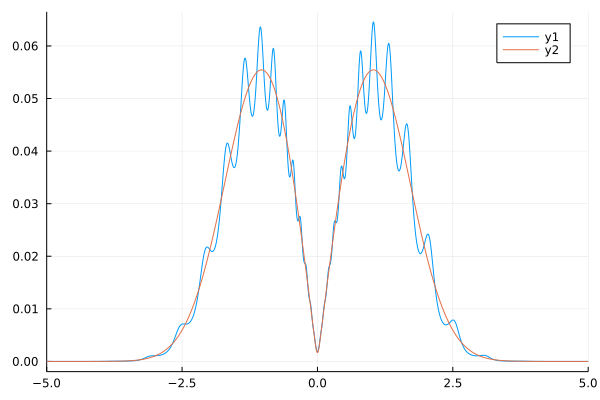

In [20]:
plot(xlim = [-5,5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi))
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))